# Tasks

### Install packages

In [15]:
!pip install mpl_tools scikit-learn matplotlib seaborn conllu seqeval


[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Dataset Exploration

In [ ]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os, requests # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path

### Load the Dataset

In [17]:
# Optional: Auto-download UD English EWT r2.14 from official repo
# If you already have the Kaggle files, skip this cell.

DATA_DIR = Path('data/ud_en')
DATA_DIR.mkdir(parents=True, exist_ok=True)
 
base = 'https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/r2.14'
files = {
    'train.conllu': 'en_ewt-ud-train.conllu',
    'dev.conllu':   'en_ewt-ud-dev.conllu',
    'test.conllu':  'en_ewt-ud-test.conllu',
}
 
for out_name, src_name in files.items():
    out_path = DATA_DIR/out_name
    if not out_path.exists():
        url = f"{base}/{src_name}"
        print('Downloading', url)
        r = requests.get(url)
        r.raise_for_status()
        out_path.write_bytes(r.content)
 
print('Data files present:', list(DATA_DIR.iterdir()))
 

Data files present: [WindowsPath('data/ud_en/dev.conllu'), WindowsPath('data/ud_en/test.conllu'), WindowsPath('data/ud_en/train.conllu')]


In [20]:
# Basic stats and samples from UD English EWT dataset

from conllu import parse_incr
from pathlib import Path
from collections import Counter
import random
 
DATA_DIR = Path('data/ud_en')
TRAIN = DATA_DIR/'train.conllu'
DEV   = DATA_DIR/'dev.conllu'
TEST  = DATA_DIR/'test.conllu'
assert TRAIN.exists() and DEV.exists() and TEST.exists(), 'Missing .conllu files in data/ud_en/'
 
 
def read_conllu(path):
    with open(path, 'r', encoding='utf-8') as f:
        for sent in parse_incr(f):
            tokens = [t['form'] for t in sent if isinstance(t['id'], int)]
            tags   = [t['upostag'] for t in sent if isinstance(t['id'], int)]
            yield tokens, tags
 
train = list(read_conllu(TRAIN))
dev   = list(read_conllu(DEV))
test  = list(read_conllu(TEST))
 
len_train, len_dev, len_test = len(train), len(dev), len(test)
print(f"Number of sentences (train) : {len_train}")
print(f"Number of sentences (dev) : {len_dev}")
print(f"Number of sentences (test) : {len_test}")

Number of sentences (train) : 12544
Number of sentences (dev) : 2001
Number of sentences (test) : 2077


### Analyze

#### Number of sentences and tokens

In [21]:
all_sents = train + dev + test
num_sentences = len(all_sents)
num_tokens = sum(len(s[0]) for s in all_sents)
avg_len = num_tokens / num_sentences
 
print(f"Total sentences: {num_sentences}")
print(f"Total tokens: {num_tokens}")


Total sentences: 16622
Total tokens: 254821


#### POS tag distribution

Convert the data into a suitable format for training a sequence labeling model (POS tagging)

In [9]:
tag_counter = Counter(tag for _, tags in all_sents for tag in tags)

for tag, c in tag_counter.most_common(20):
    print(f"{tag:>5}: {c}")

 NOUN: 43156
PUNCT: 29768
 VERB: 27890
 PRON: 23044
  ADP: 21866
  DET: 20098
  ADJ: 16812
PROPN: 16563
  AUX: 15924
  ADV: 12507
CCONJ: 8204
 PART: 7044
  NUM: 5052
SCONJ: 4603
 INTJ: 930
  SYM: 913
    X: 447


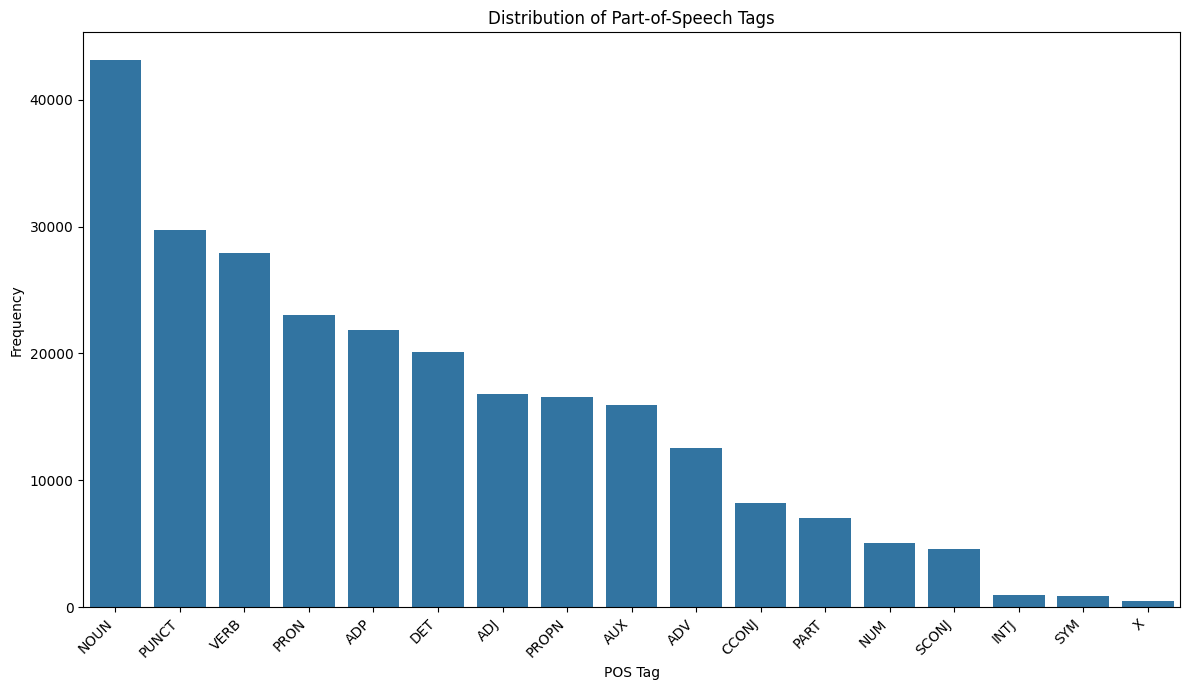

In [10]:
import pandas as pd
import seaborn as sns

# Convert the tag_counter to a DataFrame for easier plotting
tag_df = pd.DataFrame(tag_counter.most_common(), columns=['Tag', 'Count'])
 
plt.figure(figsize=(12, 7))
sns.barplot(x='Tag', y='Count', data=tag_df)
plt.title('Distribution of Part-of-Speech Tags')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Average sentence lengths

In [11]:
print(f"Average sentence length: {avg_len:.2f}")

Average sentence length: 15.33


### Sample 

In [12]:
print("Tokens with UPOS tags for five random sentences:")
for num in range(5):
    tokenSentence, tagSentence = random.choice(all_sents)
    print(f"Random Sentence {num+1}:",end="\n")
    for token, tag in zip(tokenSentence, tagSentence):
        print(f"{token} [{tag}]",end=" ")
    print("\n")


Tokens with UPOS tags for five random sentences:
Random Sentence 1:
This [DET] school [NOUN] is [AUX] the [DET] worst [ADJ] one [NOUN] i [PRON] 've [AUX] ever [ADV] been [AUX] to [ADP] . [PUNCT] 

Random Sentence 2:
I [PRON] was [AUX] told [VERB] to [PART] take [VERB] my [PRON] coffee [NOUN] to [PART] go [VERB] if [SCONJ] I [PRON] wanted [VERB] to [PART] finish [VERB] it [PRON] . [PUNCT] 

Random Sentence 3:
The [DET] email [NOUN] confirmation [NOUN] ( [PUNCT] which [PRON] I [PRON] read [VERB] in [ADP] the [DET] car [NOUN] ) [PUNCT] warned [VERB] about [ADP] large [ADJ] suitcases [NOUN] , [PUNCT] declaring [VERB] that [SCONJ] we [PRON] are [AUX] innkeepers [NOUN] , [PUNCT] not [PART] longshoreman [NOUN] . [PUNCT] 

Random Sentence 4:
We [PRON] 've [AUX] had [VERB] a [DET] few [ADJ] since [ADP] then [ADV] , [PUNCT] but [CCONJ] none [NOUN] since [SCONJ] our [PRON] race [NOUN] horses [NOUN] began [VERB] wintering [VERB] in [ADP] Florida [PROPN] . [PUNCT] 

Random Sentence 5:
I [PRON] am [

In [22]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from seqeval.metrics import classification_report, accuracy_score, f1_score

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'


def build_vocab(sentences, min_freq=1):
    wc = Counter(tok.lower() for toks, _ in sentences for tok in toks)
    itos = [PAD_TOKEN, UNK_TOKEN] + [w for w, c in wc.items() if c >= min_freq]
    stoi = {w:i for i, w in enumerate(itos)}
    return stoi, itos


def build_tag_map(sentences):
    tags = sorted({t for _, ts in sentences for t in ts})
    tag2id = {t:i for i, t in enumerate(tags)}
    id2tag = {i:t for t, i in tag2id.items()}
    return tag2id, id2tag


word2id, id2word = build_vocab(train)
tag2id, id2tag   = build_tag_map(train)
PAD_ID = word2id[PAD_TOKEN]


MAX_LEN = 128


def vectorize(tokens, tags=None, max_len=MAX_LEN):
    ids = [word2id.get(tok.lower(), word2id[UNK_TOKEN]) for tok in tokens]
    tids = None
    if tags is not None:
        tids = [tag2id[t] for t in tags]
    if max_len is not None:
        ids = ids[:max_len]
        if tids is not None:
            tids = tids[:max_len]
    return ids, tids


class SeqDataset(Dataset):
    def __init__(self, samples, max_len=MAX_LEN):
        self.samples = samples
        self.max_len = max_len
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        tokens, tags = self.samples[idx]
        wi, ti = vectorize(tokens, tags, self.max_len)
        return wi, ti


def collate(batch):
    xs, ys = zip(*batch)
    max_len = max(len(x) for x in xs)
    px = [x + [PAD_ID]*(max_len-len(x)) for x in xs]
    py = [y + [-100]*(max_len-len(y)) for y in ys]  # -100 ignored in CrossEntropyLoss
    attn = [[1]*len(x) + [0]*(max_len-len(x)) for x in xs]
    return (torch.tensor(px, dtype=torch.long),
            torch.tensor(py, dtype=torch.long),
            torch.tensor(attn, dtype=torch.bool))


train_dl = DataLoader(SeqDataset(train), batch_size=64, shuffle=True, collate_fn=collate)
dev_dl   = DataLoader(SeqDataset(dev),   batch_size=128, shuffle=False, collate_fn=collate)
test_dl  = DataLoader(SeqDataset(test),  batch_size=128, shuffle=False, collate_fn=collate)


def evaluate_sequences(true_ids, pred_ids):
    all_true, all_pred = [], []
    for y, p in zip(true_ids, pred_ids):
        y_tags = [id2tag[i] for i in y]
        p_tags = [id2tag[i] for i in p]
        all_true.append(y_tags)
        all_pred.append(p_tags)
    acc = accuracy_score(all_true, all_pred)
    macro_f1 = f1_score(all_true, all_pred, average='macro')
    micro_f1 = f1_score(all_true, all_pred, average='micro')
    report = classification_report(all_true, all_pred, digits=4)
    return acc, macro_f1, micro_f1, report


## Baseline POS tagger

In [23]:
import os, random, statistics, math
from collections import Counter
import numpy as np
import torch

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


In [27]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, num_tags, emb_dim=100, hidden_dim=256, num_layers=1, dropout=0.2, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, hidden_dim//2, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers>1 else 0,
                            bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_tags)

    def forward(self, x, mask=None):
        e = self.emb(x)                     # (B, T, E)
        out, _ = self.lstm(e)               # (B, T, H)
        out = self.dropout(out)
        logits = self.fc(out)               # (B, T, C)
        return logits


def train_epoch(model, dl, optimizer, criterion):
    model.train()
    total = 0.0
    for X, Y, M in dl:
        X, Y, M = X.to(device), Y.to(device), M.to(device)
        optimizer.zero_grad()
        logits = model(X, M)
        loss = criterion(logits.view(-1, logits.size(-1)), Y.view(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item()
    return total / max(1, len(dl))

@torch.no_grad()
def evaluate_model(model, dl):
    model.eval()
    all_true, all_pred = [], []
    for X, Y, M in dl:
        X, Y, M = X.to(device), Y.to(device), M.to(device)
        logits = model(X, M)
        pred = logits.argmax(-1)
        for y, p, m in zip(Y, pred, M):
            y = y[m].tolist()
            p = p[m].tolist()
            all_true.append(y)
            all_pred.append(p)
    acc, macro_f1, micro_f1, report = evaluate_sequences(all_true, all_pred)
    return acc, macro_f1, micro_f1, report

### Train Baseline POS Tagger

In [28]:
model_baseline = BiLSTMTagger(vocab_size=len(id2word), num_tags=len(tag2id), pad_idx=PAD_ID).to(device)
optimizer = torch.optim.AdamW(model_baseline.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

EPOCHS = 8
for epoch in range(EPOCHS):
    tr_loss = train_epoch(model_baseline, train_dl, optimizer, criterion)
    accuracy, mF1, uF1, report = evaluate_model(model_baseline, dev_dl)
    print(f"Epoch {epoch+1:02d} | train_loss={tr_loss:.4f} | dev_acc={accuracy:.4f} | dev_macroF1={mF1:.4f}")

c:\Users\mkathamu\OneDrive - Qualcomm\Documents\MTech\Courses\S2\NLP\nlp\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: ADP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\mkathamu\OneDrive - Qualcomm\Documents\MTech\Courses\S2\NLP\nlp\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: DET seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\mkathamu\OneDrive - Qualcomm\Documents\MTech\Courses\S2\NLP\nlp\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PROPN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\mkathamu\OneDrive - Qualcomm\Documents\MTech\Courses\S2\NLP\nlp\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: VERB seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\mkathamu\OneDrive - Qualcomm\Documents\MTech\Courses

Epoch 01 | train_loss=0.7800 | dev_acc=0.8642 | dev_macroF1=0.7615
Epoch 02 | train_loss=0.2976 | dev_acc=0.9000 | dev_macroF1=0.8063
Epoch 03 | train_loss=0.1783 | dev_acc=0.9097 | dev_macroF1=0.8177
Epoch 04 | train_loss=0.1113 | dev_acc=0.9148 | dev_macroF1=0.8206
Epoch 05 | train_loss=0.0696 | dev_acc=0.9170 | dev_macroF1=0.8249
Epoch 06 | train_loss=0.0439 | dev_acc=0.9181 | dev_macroF1=0.8309
Epoch 07 | train_loss=0.0286 | dev_acc=0.9182 | dev_macroF1=0.8325
Epoch 08 | train_loss=0.0189 | dev_acc=0.9199 | dev_macroF1=0.8332


### Train accuracy

In [33]:
print(f"Dev Accuracy : {100*accuracy:.3} %")
print(f"Dev report (Baseline): {report}")

Dev Accuracy : 92.0 %
Dev report (Baseline):               precision    recall  f1-score   support

         ART     0.9597    0.9567    0.9582       647
        CONJ     0.9484    0.9329    0.9406      1163
          DJ     0.8899    0.8541    0.8716      1761
          DP     0.9347    0.9549    0.9447      1994
          DV     0.8956    0.8535    0.8741      1106
         ERB     0.9128    0.9066    0.9097      2656
          ET     0.9814    0.9830    0.9822      1879
         NTJ     0.9167    0.6875    0.7857       112
         OUN     0.8367    0.8410    0.8389      3711
         RON     0.9823    0.9795    0.9809      2150
        ROPN     0.6196    0.7139    0.6634      1419
          UM     0.8980    0.7437    0.8136       355
        UNCT     0.9912    0.9888    0.9900      2945
          UX     0.9820    0.9739    0.9779      1455
          YM     0.8525    0.6265    0.7222        83
           _     0.1429    0.0526    0.0769        19

   micro avg     0.9081    0.9070  

### Test accuracy

In [31]:
test_accuracy, mF1_t, uF1_t, test_report = evaluate_model(model_baseline, test_dl)
print(f"Test Accuracy: {test_accuracy*100:.3} %")
print("Test Report (Baseline):", test_report)

c:\Users\mkathamu\OneDrive - Qualcomm\Documents\MTech\Courses\S2\NLP\nlp\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PRON seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\mkathamu\OneDrive - Qualcomm\Documents\MTech\Courses\S2\NLP\nlp\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: SCONJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\mkathamu\OneDrive - Qualcomm\Documents\MTech\Courses\S2\NLP\nlp\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PROPN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\mkathamu\OneDrive - Qualcomm\Documents\MTech\Courses\S2\NLP\nlp\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: VERB seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\mkathamu\OneDrive - Qualcomm\Documents\MTech\Cour

Test Accuracy: 92.0 %
Test Report (Baseline):               precision    recall  f1-score   support

         ART     0.9660    0.9705    0.9683       645
        CONJ     0.9545    0.9468    0.9507      1109
          DJ     0.8994    0.8548    0.8765      1694
          DP     0.9473    0.9492    0.9482      1969
          DV     0.8931    0.8831    0.8881      1078
         ERB     0.9252    0.9245    0.9248      2569
          ET     0.9856    0.9861    0.9859      1874
         NTJ     0.9231    0.8136    0.8649       118
         OUN     0.8294    0.8331    0.8313      3578
         RON     0.9844    0.9834    0.9839      2114
        ROPN     0.6092    0.7145    0.6576      1562
          UM     0.9019    0.6800    0.7754       500
        UNCT     0.9909    0.9862    0.9885      2967
          UX     0.9830    0.9782    0.9806      1422
          YM     0.8235    0.7706    0.7962       109
           _     0.1250    0.0625    0.0833        16

   micro avg     0.9077    0.9082 